In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as mpl
import pandas as pd
import seaborn as sns

import time
import sys
%matplotlib inline

In [ ]:
from parity_machines.tree_machine import TreeParityMachine

In [ ]:
def test_sync(k, n, l, update_rule='hebbian', echo=False, max_time=float('inf')):

	A = TreeParityMachine(n, k, l, update_rule=update_rule)
	B = TreeParityMachine(n, k, l, update_rule=update_rule)
	E = TreeParityMachine(n, k, l, update_rule=update_rule)

	def sync_score(m1, m2):
		return 1.0 - np.average(1.0 * np.abs(m1.W - m2.W)/(2 * l))

	sync = False 
	updates = 0
	eve_updates = 0 
	scores = [] 
	eve_scores = []

	t1 = time.time()
	while(not sync):
		X = A.generate_input()

		y_A = A.forward(X) 
		y_B = B.forward(X) 
		y_E = E.forward(X) 
		A.update(y_B)
		B.update(y_A)
		updates += 1

		if y_A == y_B == y_E:
			E.update(y_A)
			eve_updates += 1

		score = sync_score(A, B) 
		scores.append(score)
		score_EA = sync_score(A, E)
		score_EB = sync_score(B, E)
		eve_scores.append((score_EA, score_EB))

		sync = A.synced()

		score_format = lambda s: str(int(s * 100))
		if echo:
			sys.stdout.write(f"\rSynchronization(AB, EA, EB) = ({score_format(score)}, {score_format(score_EA)}, {score_format(score_EB)})%   /" \
			+ f"  Updates(AB, EAB)  = ({str(updates)}, {str(eve_updates)})") 
	
	if time.time() - t1 > max_time:
		raise TimeoutError()



	time_taken = time.time() - t1

	if echo:
		if sync:
			print('\nAlice and Bob are synchronized.')
		if eve_scores[-1][0] == 1:
			print('Eve is also synchornized !!!')
	return {'synced': (A.W == B.W).all(),
	 		'e-synced': (A.W == B.W).all() and (B.W == E.W).all(),
	  		'time': time_taken,
	    	'updates': updates,
		  	'eve_updates': eve_updates,
		    'alice': A, 'bob': B, 'eve': E,
			'scores': np.array(scores),
			'eve_scores': np.array(eve_scores),
			'k': k,
			'n':n,
			'l':l,
			'update_rule':update_rule}


def plot_res(res):
    scores = res['scores']
    eve_scores= res['eve_scores']

    mpl.plot(scores)
    mpl.plot(eve_scores[:, 0])
    mpl.plot(eve_scores[:, 1])
    plt.xlabel('updates')
    plt.ylabel('sync score')
    plt.legend(['Alice/Bob score', 'Eve/Alice score', 'Eve/Bob score'])
    plt.title(f"Sync progress for k={res['k']}, n={res['n']}, l={res['l']}, up_rule: {res['update_rule']}\n" + \
	      f"AB synced: {res['synced']}, ABE synced: {res['e-synced']}")
    print('Synced: ' + str(res['synced']))


In [ ]:
# update_rules = ['hebbian', 'anti_hebbian', 'random_walk']
# res = test_sync(k=2, n=10, l=2, update_rule=update_rules[0], echo=True, max_time=55)
# plot_res(res)

In [ ]:
import pickle
k=2
reps = 100
res= {}
ctr = 0
for rule in ['hebbian', 'anti_hebbian', 'random_walk']:
    for n in [20, 30, 40, 50]:
        for l in [1, 8, 64, 128, 256]:
            subs = []
            for _ in range(reps):
                ctr += 1
                sres = test_sync(k=k, n=n, l=l, update_rule=rule, echo=False, max_time=55)
                subs.append(sres['updates'])
                sys.stdout.write(f"\r{ctr} / {3 * 4 * 5 * reps}")
            res[(k, n, l, rule)] = subs
with open('tree-test-results.pkl', 'wb') as f:
    pickle.dump(res, f)


In [ ]:
with open('tree-test-results.pkl', 'rb') as f:
    tres = pickle.load(f)

In [101]:
rows = []
for k in tres:
    r = tres[k]
    rowh = dict(zip(['k', 'n', 'l', 'rule'], k))
    for ups in r:
        row = rowh | {'updates': ups}
        rows.append(row)

In [102]:
df = pd.DataFrame.from_dict(rows)
df.loc[df['rule'] == 'hebbian']

,k,n,l,rule,updates
0,2,20,1,hebbian,107
1,2,20,1,hebbian,50
2,2,20,1,hebbian,221
3,2,20,1,hebbian,81
4,2,20,1,hebbian,61
...,...,...,...,...,...
1995,2,50,256,hebbian,388
1996,2,50,256,hebbian,385
1997,2,50,256,hebbian,414
1998,2,50,256,hebbian,325


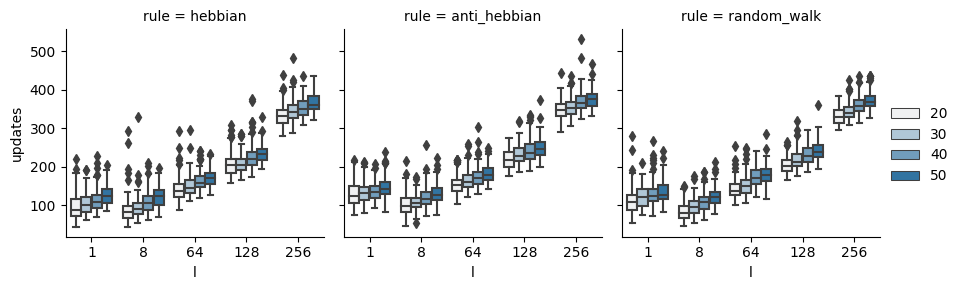

In [108]:
g = sns.FacetGrid(df, col="rule")
g.map_dataframe(sns.boxplot, data=df, x="l", y='updates', hue='n')
g.add_legend()


<AxesSubplot: xlabel='l', ylabel='updates'>

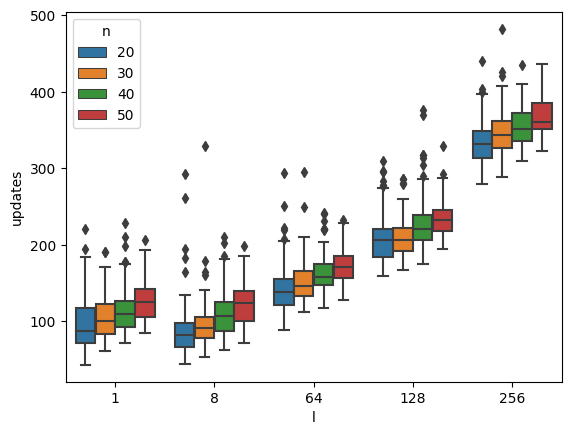

In [109]:
sns.boxplot(data=df.loc[df['rule'] == 'random'], x='l', y='updates', hue='n')

In [ ]:
# scolumns = [f"s{i}" for i in range(100)]
# dfr = df.loc[df['rule'] == 'hebbian'].drop(columns='rule')
# dfr['mean'] = dfr[scolumns].mean(axis=1)
# dfr['std'] = dfr[scolumns].std(axis=1)
# dfr.head()

In [ ]:
# ctr = 0
# correct = 0
# nc = []
# D = (10, 30)
# iters = 10
# mi = iters * (D[1] - D[0]) ** 3
# for k in range(10, 20):
#     for n in range(k + 10, k + 30):
#         for l in range(*D):
#             for _ in range(iters):
#                 ctr += 1
#                 res = test_sync(k=k, n=n, l=l, update_rule='hebbian', echo=False, max_time=55)
#                 synced = res['synced']
#                 correct += synced
#                 if not synced:
#                     print(f'oops!!!: {len(nc)}\n')
#                     nc.append((k,n,l))
#                 sys.stdout.write(f"\r {ctr} / {mi}")



In [ ]:
alice = res['alice']
bob = res['bob']
eve = res['eve']